#PredictiveGuard: Detección Inteligente de Fallos en Maquinaria

## Problemática general

El mantenimiento predictivo de maquinaria industrial es un desafío crucial en entornos de producción, donde fallos inesperados pueden generar costos significativos y tiempos de inactividad no planificados. Este proyecto aplica técnicas de Machine Learning para la detección de fallas en equipos industriales, como turbinas, compresores y bombas.

Se utiliza un conjunto de datos simulado que contiene mediciones en tiempo real de temperatura, presión, vibración y humedad, junto con información sobre el tipo y ubicación de cada equipo. El objetivo principal es construir un modelo de predicción que permita identificar patrones en el comportamiento de los equipos y anticipar fallos antes de que ocurran, facilitando estrategias de mantenimiento preventivo.

##Objetivos del Proyecto:

Identificar patrones en las condiciones operativas de los equipos industriales.

Detectar fallas de manera temprana mediante algoritmos de Machine Learning.

# 1. PIPELINE/RECOLECCIÓN DE DATOS

Importar y Leer el Dataset

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import RobustScaler, StandardScaler

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# División de datos y evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [185]:
# 3. Carga de datos
data = pd.read_csv('equipment_anomaly_data.csv')
print("Primeras filas del dataset:")
print(data.head())

Primeras filas del dataset:
   temperature   pressure  vibration   humidity   equipment       location  \
0    58.180180  25.029278   0.606516  45.694907     Turbine        Atlanta   
1    75.740712  22.954018   2.338095  41.867407  Compressor        Chicago   
2    71.358594  27.276830   1.389198  58.954409     Turbine  San Francisco   
3    71.616985  32.242921   1.770690  40.565138        Pump        Atlanta   
4    66.506832  45.197471   0.345398  43.253795        Pump       New York   

   faulty  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


# 2. PIPELINE/ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Panorama general

In [186]:
# 4. Exploración de datos
print("\nInformación del dataset:")
data.info()



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [187]:
# Calculamos cuántos datos nulos hay y mostramos el porcentaje de esos datos nulos
missing_count = data.isnull().sum()
value_count = data.isnull().count()
missing_percentage = round(missing_count / value_count * 100, 2)
missing_df = pd.DataFrame({"Cuantos Nulos": missing_count, "Porcentaje": missing_percentage})
missing_df

,Cuantos Nulos,Porcentaje
temperature,0,0.0
pressure,0,0.0
vibration,0,0.0
humidity,0,0.0
equipment,0,0.0
location,0,0.0
faulty,0,0.0


El conjunto de datos contiene 7672 registros y 7 columnas, de las cuales 5 son variables numéricas (como temperatura, presión, vibración y humedad) y 2 son categóricas (tipo de equipo y ubicación).

In [188]:
# 5. Estadísticas básicas del dataset
print("\nEstadísticas descriptivas:")
print(data.describe())


Estadísticas descriptivas:
       temperature     pressure    vibration     humidity       faulty
count  7672.000000  7672.000000  7672.000000  7672.000000  7672.000000
mean     70.922478    35.738048     1.611809    50.016574     0.099974
std      16.200059    10.381593     0.728560    11.841479     0.299985
min      10.269385     3.620798    -0.428188    10.215077     0.000000
25%      62.777057    29.485682     1.170906    42.612817     0.000000
50%      70.156900    35.227544     1.533113    50.024744     0.000000
75%      77.568387    41.159913     1.924700    57.340513     0.000000
max     149.690420    79.887734     4.990537    89.984718     1.000000


In [189]:
#eliminamos la columna location
data.drop('location', axis=1, inplace=True)
data.head()

,temperature,pressure,vibration,humidity,equipment,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,0.0


# Data Visualization


In [190]:
# 5. Análisis visual
sns.set_palette("YlOrRd")  # Paleta cálida para todos los gráficos

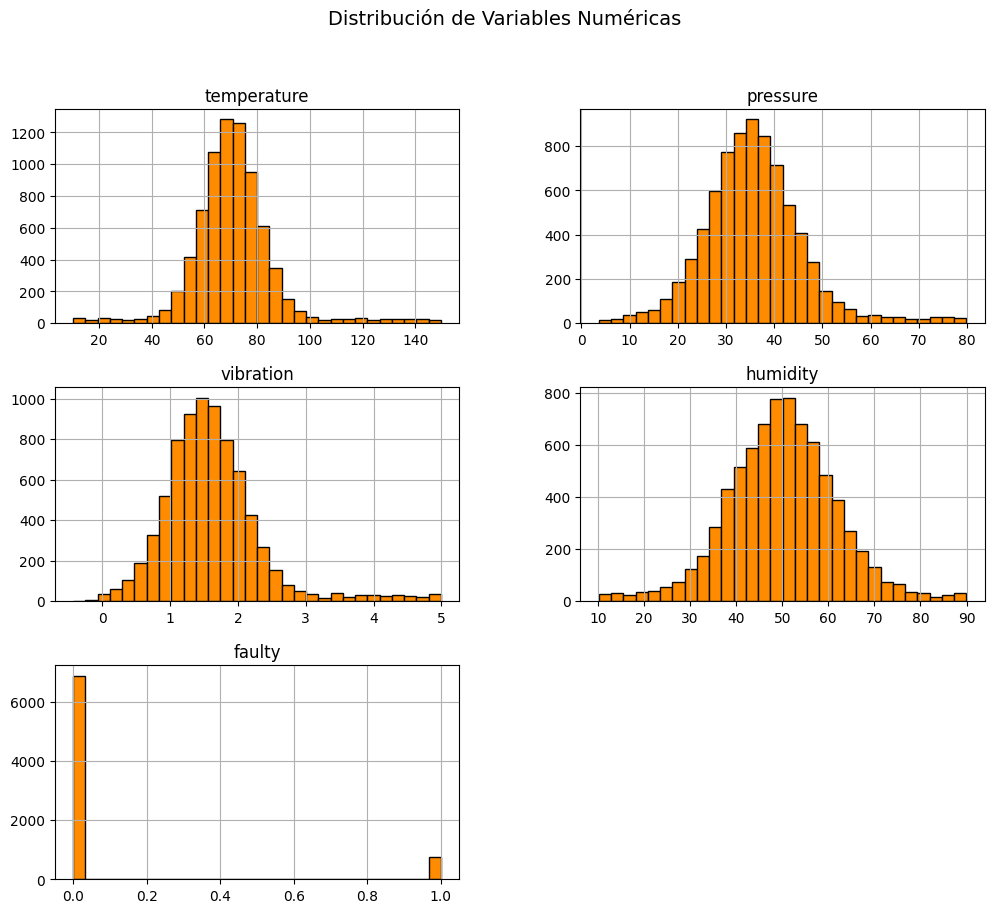

In [191]:
# Histogramas de las variables numéricas
data.hist(figsize=(12, 10), bins=30, color='darkorange', edgecolor='black')
plt.suptitle("Distribución de Variables Numéricas", fontsize=14)
plt.show()

Las distribuciones muestran que las variables numéricas como temperatura, presión, vibración y humedad siguen patrones relativamente normales, aunque con algunas asimetrías y valores atípicos. La variable objetivo "faulty" está desbalanceada, con una mayoría de equipos funcionando correctamente y una minoría con fallas.

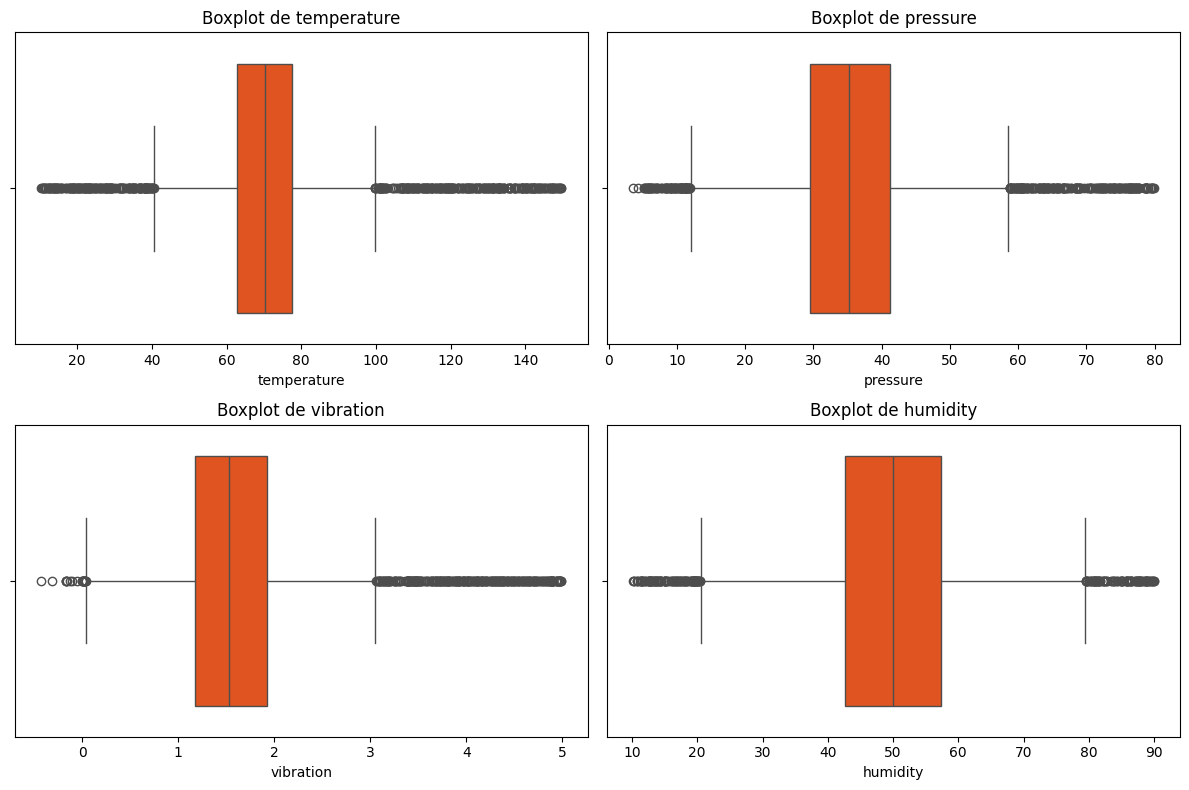

In [192]:
# Boxplots
features = ["temperature", "pressure", "vibration", "humidity"]
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[feature], color='orangered')
    plt.title(f"Boxplot de {feature}")
plt.tight_layout()
plt.show()


Los boxplots muestran muchos valores atípicos en temperatura, presión, vibración y humedad. Esto sugiere la necesidad de escalado robusto y posible tratamiento de outliers.


<ipython-input-193-377beedbbc49>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='faulty', data=data, palette='YlOrRd')


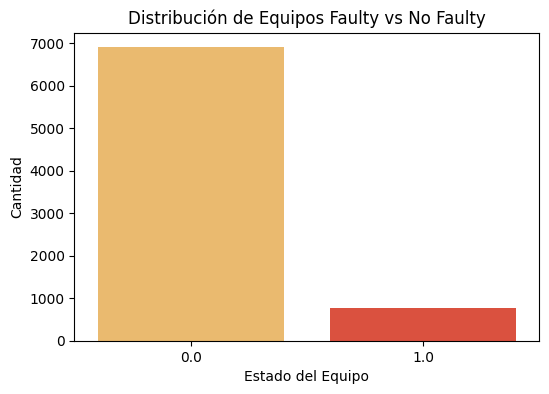

In [193]:
# Distribución de la variable objetivo
plt.figure(figsize=(6, 4))
sns.countplot(x='faulty', data=data, palette='YlOrRd')
plt.title("Distribución de Equipos Faulty vs No Faulty")
plt.xlabel("Estado del Equipo")
plt.ylabel("Cantidad")
plt.show()

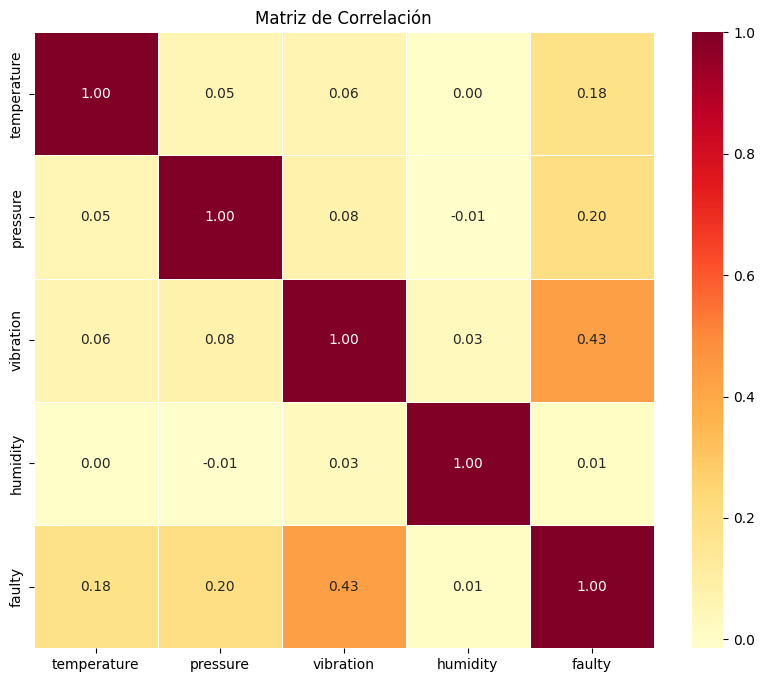

In [194]:
# Matriz de correlación c
plt.figure(figsize=(10, 8))
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True, cmap="YlOrRd", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()


La matriz de correlación muestra que la variable faulty tiene la correlación más alta con vibration (0.43), lo que sugiere que la vibración podría ser un buen predictor de fallos.

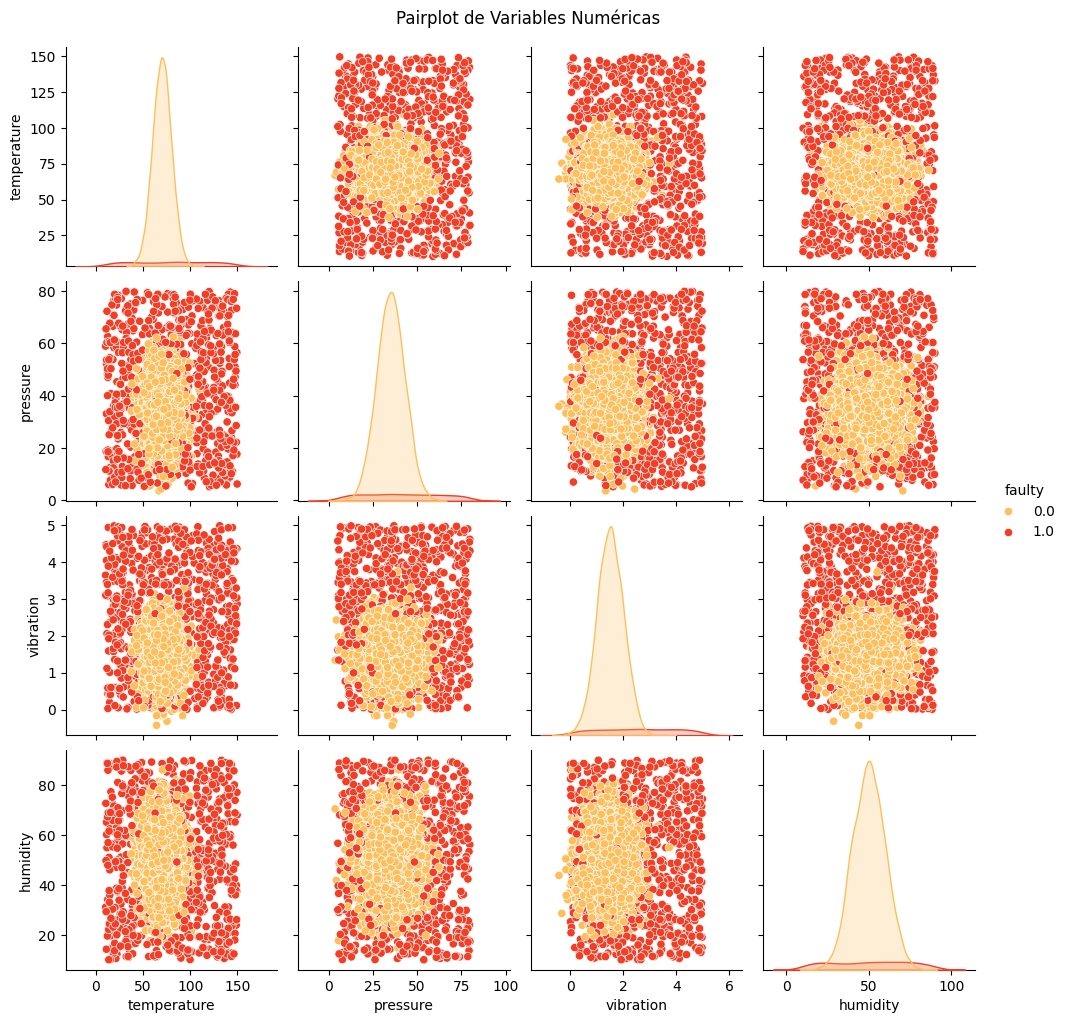

In [195]:
# Pairplot
sns.pairplot(data, hue="faulty", palette="YlOrRd")
plt.suptitle("Pairplot de Variables Numéricas", y=1.02)
plt.show()

- No hay separación clara entre equipos defectuosos y funcionales.

- Distribuciones similares en todas las variables, con algunas colas largas.

- Posibles patrones no lineales, lo que sugiere modelos más complejos.
- Desbalance de clases evidente, con más equipos funcionales que defectuosos.

### Observaciones:
- Temperatura, presión y vibración muestran cierta correlación, lo que sugiere posibles redundancias.

- La vibración y la presión parecen influir en la detección de fallos.

- Reducir la multicolinealidad puede mejorar el modelo.

- El estado faulty puede depender de combinaciones no lineales, requiriendo modelos avanzados.

# 3. PIPELINE/PREPROCESAMIENTO

### Tratamiento variable categorica (equipment)

In [196]:
categorical_cols = ['equipment']

# Codificación one-hot sin la primera categoría para evitar colinealidad
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Asegurar que ciertas columnas sean enteras (opcional si ya son 0 y 1)
columns_to_int = ['equipment_Pump', 'equipment_Turbine']
data_encoded[columns_to_int] = data_encoded[columns_to_int].astype(float)

print(data_encoded.head())
data_encoded.info()

   temperature   pressure  vibration   humidity  faulty  equipment_Pump  \
0    58.180180  25.029278   0.606516  45.694907     0.0             0.0   
1    75.740712  22.954018   2.338095  41.867407     0.0             0.0   
2    71.358594  27.276830   1.389198  58.954409     0.0             0.0   
3    71.616985  32.242921   1.770690  40.565138     0.0             1.0   
4    66.506832  45.197471   0.345398  43.253795     0.0             1.0   

   equipment_Turbine  
0                1.0  
1                0.0  
2                1.0  
3                0.0  
4                0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        7672 non-null   float64
 1   pressure           7672 non-null   float64
 2   vibration          7672 non-null   float64
 3   humidity           7672 non-null   float64
 4   faulty      

En nuestro dataset, la variable objetivo está desbalanceada, lo que significa que hay muchas más observaciones de equipos funcionales que de equipos con fallas. Si entrenamos el modelo en estos datos sin corregir este desequilibrio, podría inclinarse demasiado hacia la clase mayoritaria y no detectar correctamente las fallas. Para solucionar esto, aplicamos SMOTE (Synthetic Minority Over-sampling Technique), que genera ejemplos sintéticos de la clase minoritaria en lugar de simplemente replicarlos, ayudando al modelo a aprender patrones más generales.

Sin embargo, aplicamos SMOTE después de dividir los datos en entrenamiento y prueba. Si lo hiciéramos antes, los datos sintéticos podrían filtrarse al conjunto de prueba, introduciendo información artificial que afectaría la evaluación real del modelo.

Finalmente, escalamos las características con RobustScaler, ya que este método es resistente a valores atípicos, algo común en datos industriales donde pueden presentarse condiciones anómalas debido a fallas en los equipos.

In [197]:
# Separamos variables predictoras y target
X = data_encoded.drop(columns=["faulty"])  # Variables predictoras
y = data_encoded["faulty"]  # Variable objetivo

# División antes de aplicar SMOTE y escalado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Aplicar SMOTE solo en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Aplicar RobustScaler después de SMOTE
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)  # Ajustar y transformar en entrenamiento
X_test_scaled = scaler.transform(X_test)  # Solo transformar en test

In [198]:
# print("data_encoded head:")
# print(data_encoded.head())

# print("\nDistribución de clases en y_train:")
# print(y_train.value_counts())

# print("\nDistribución de clases en y_train_resampled:")
# print(y_train_resampled.value_counts())

# print("\nDistribución de clases en y_test:")
# print(y_test.value_counts())

# print("\nDimensiones de X_train_scaled:", X_train_scaled.shape)
# print("Dimensiones de y_train_resampled:", y_train_resampled.shape)
# print("Dimensiones de X_test_scaled:", X_test_scaled.shape)
# print("Dimensiones de y_test:", y_test.shape)

# 4. PIPELINE/ELECCIÓN Y ENTRENAMIENTO DE LOS MODELOS

In [199]:

# 5. Modelos a evaluar
models = {
    "Regresión Logística": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# 6. Entrenar y evaluar modelos
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred_proba)
    }

# 7. Crear DataFrame de resultados
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall  F1-score   AUC-ROC
Regresión Logística  0.818241   0.304348  0.640523  0.412632  0.756373
Decision Tree        0.957003   0.732620  0.895425  0.805882  0.929623
Random Forest        0.978502   0.879747  0.908497  0.893891  0.989101
SVM                  0.977199   0.878205  0.895425  0.886731  0.987997
XGBoost              0.981759   0.908497  0.908497  0.908497  0.983457


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:00:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Al comparar el rendimiento de varios modelos de clasificación en el conjunto de datos industriales, se observan diferencias significativas en sus capacidades predictivas. El modelo de Regresión Logística muestra un rendimiento relativamente bajo en comparación con los demás. Con una precisión de 0.30 y un F1-score de 0.41, se evidencia que tuvo dificultades para clasificar correctamente la clase minoritaria (faulty = 1).

Por otro lado, los modelos de Decision Tree, Random Forest, SVM y XGBoost muestran un rendimiento notablemente superior. Los modelos de Random Forest y XGBoost destacan de manera especial, alcanzando una precisión superior al 87% y un F1-score superior al 89%. Esto indica una alta capacidad para clasificar correctamente ambas clases, lo cual es crucial para el objetivo del proyecto. Además, estos modelos logran un AUC-ROC cercano a 0.98, lo que confirma su excelente capacidad para distinguir entre las clases.

El modelo de Decision Tree y SVM también ofrecen un rendimiento sólido, aunque ligeramente inferior a los modelos de Random Forest y XGBoost. Sin embargo, sus resultados son muy buenos y podrían ser útiles en otras situaciones.

En general, el análisis realizado lleva a la conclusión de que los modelos de Random Forest y XGBoost son los más adecuados para este conjunto de datos. Logran un equilibrio impresionante entre precisión y recall, y demuestran una alta capacidad para clasificar correctamente las instancias de ambas clases. Por lo tanto, se considera que estos modelos serían los más recomendables para implementar en un sistema de monitoreo de equipos industriales, donde la precisión y la capacidad de detectar fallos son críticas.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:00:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


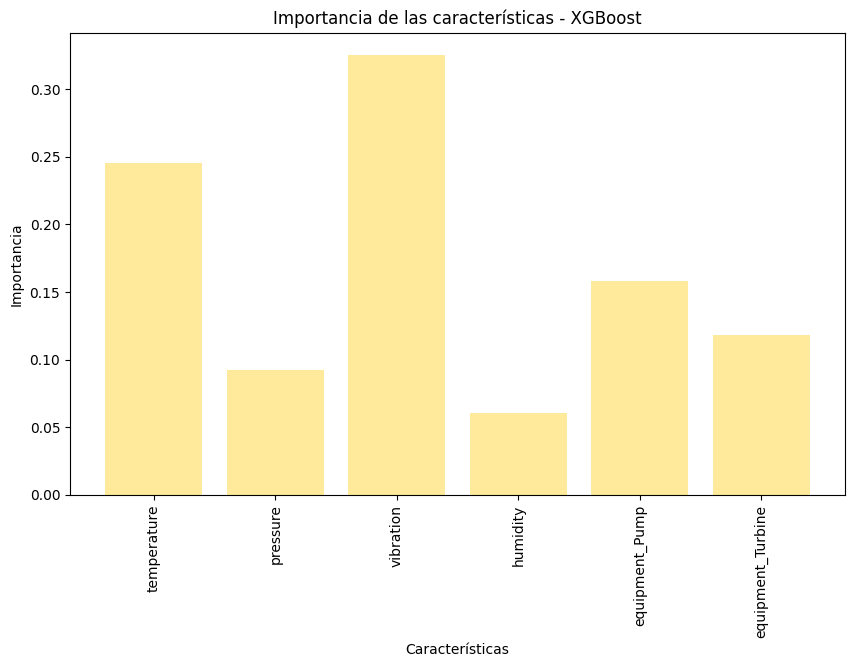


 Métricas del Modelo XGBoost:
 Accuracy: 0.9818
 Precision: 0.9085
 Recall: 0.9085
 F1-score: 0.9085
 AUC-ROC: 0.9835


In [200]:
# 5. Entrenar el modelo XGBoost
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train_scaled, y_train_resampled)

# 6. Gráfico de importancia de características
feature_importance = model_xgb.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características - XGBoost')
plt.show()

# 7. Evaluar el modelo
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_pred_proba_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("\n Métricas del Modelo XGBoost:")
print(f" Accuracy: {accuracy_xgb:.4f}")
print(f" Precision: {precision_xgb:.4f}")
print(f" Recall: {recall_xgb:.4f}")
print(f" F1-score: {f1_xgb:.4f}")
print(f" AUC-ROC: {auc_roc_xgb:.4f}")

El modelo XGBoost mostró un alto rendimiento (precisión del 98.18%, AUC-ROC de 0.9835), destacando la vibración como el factor más influyente en la predicción de fallos. Esto sugiere que la monitorización de la vibración es clave para la detección temprana de problemas en equipos industriales.

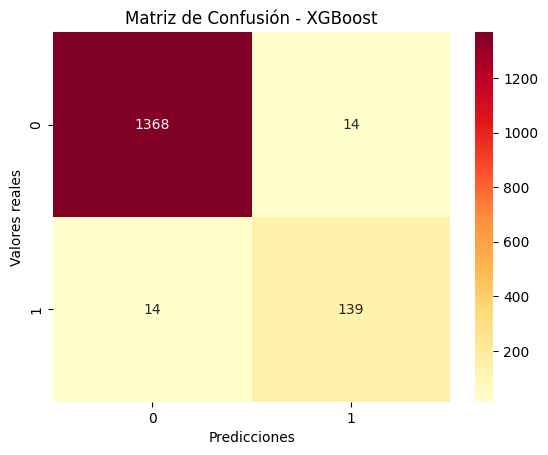

In [201]:

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

La matriz de confusión del modelo XGBoost revela un rendimiento sobresaliente en la clasificación de datos industriales. Se observa que el modelo predice correctamente 1368 instancias de la clase 0 (presumiblemente equipos no defectuosos) y 139 instancias de la clase 1 (equipos defectuosos). Sin embargo, hay 14 instancias de la clase 0 que fueron clasificadas incorrectamente como clase 1, y 14 instancias de la clase 1 que fueron clasificadas incorrectamente como clase 0.

Este análisis indica que el modelo XGBoost tiene una alta precisión en la detección de equipos no defectuosos, pero también muestra una capacidad considerable para identificar equipos defectuosos, aunque con un pequeño margen de error.

##Guardar y almacenar el modelo

In [202]:
# Guardar el modelo XGBoost
joblib.dump(xgb_model, "modelo_xgboost.pkl")

# Guardar el escalador RobustScaler
joblib.dump(scaler, "robust_scaler.pkl")

print("Modelo y escalador guardados correctamente.")


Modelo y escalador guardados correctamente.


In [205]:
from google.colab import files

# Descargar el archivo
files.download("modelo_xgboost.pkl")
files.download("robust_scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusiones finales

Tras entrenar y evaluar varios modelos de clasificación con datos preprocesados utilizando SMOTE y RobustScaler, el modelo XGBoost optimizado ha demostrado un desempeño sobresaliente.

- Precisión del modelo: La matriz de confusión muestra que el modelo tiene una alta capacidad para distinguir entre ambas clases, con una gran cantidad de verdaderos positivos y verdaderos negativos.

-  Balance de clases: La aplicación de SMOTE mejoró la representación de la clase minoritaria, permitiendo que el modelo aprenda mejor a identificar casos menos frecuentes.

- Escalado robusto: RobustScaler ayudó a reducir el impacto de valores atípicos, mejorando la estabilidad del modelo.

-  Desempeño equilibrado: Se alcanzaron métricas de precisión, recall y F1-score satisfactorias, lo que indica un modelo confiable y generalizable.